In [10]:
import pandas as pd
import numpy as np
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import re

In [3]:
file_path = '202409_Kazakhstan companies selection v3 (1).xlsx'  # Update the path if different
df = pd.read_excel(file_path)

In [4]:
df = pd.read_excel(file_path, skiprows=1)
df

,Index,Company name,Address,Latitude,Longitude,Phone,Email,Line of business/sector,ISIC Code,Average number of employees
0,1,"TOO ""PERVY PIVZAVOD""","ALMATINSKAYA OBLAST, ILISKI RAION, ASHCHIBULAK...",43.457519,76.901992,+7(727)3210000,almatybeer@mail.kz,MALT BEVERAGES,2082,251 - 500
1,2,"TOO ""ENGRAVE""","G. ALMATY, MEDEUSKI RAION, ULITSA KHADZHI MUKA...",43.226634,76.960480,+7(777)6666699,info@engrave.kz,MISCELLANEOUS METALWORK,3449,NaN
2,3,"TOO ""ARMAN""","AKMOLINSKAYA OBLAST, ZHAKSYNSKI RAION, KALININ...",52.250331,67.566030,+7(716)3522611,raeva-su@mail.ru,"FIELD CROPS, EXCEPT CASH GRAIN",139,51 - 100
3,4,"TOO ""BESTEREK-2014""","AKMOLINSKAYA OBLAST, TSELINOGRADSKI RAION, TAL...",51.243336,71.151553,+7(700)5151547,zhandos.1980@mail.ru,"GENERAL FARMS, PRIMARILY CROP",191,NaN
4,5,"TOO ""BI TEMIR""","G. SHYMKENT, AL-FARABISKI RAION, ULITSA ERIMBE...",42.335007,69.629656,+7(702)3577077,too777@inbox.ru,BLAST FURNACES AND STEEL MILLS,3312,NaN
...,...,...,...,...,...,...,...,...,...,...
317,318,"AO ""ALYUMINI KAZAKHSTANA""","PAVLODARSKAYA OBLAST, PAVLODAR G. A., G. PAVLO...",52.331792,76.925765,+7(7182)370111\n+7(7182)370808\n+7(7182)370293...,aok.paz@erg.kz,PRIMARY ALUMINUM,3334,> 1000
318,319,"TOO ""RAZDOLE""","ZAPADNO-KAZAKHSTANSKAYA OBLAST, RAION BEITEREK...",51.572368,51.837203,+7(711)3120265,razdolnenskiy_okrug@mail.ru,"FIELD CROPS, EXCEPT CASH GRAIN",139,51 - 100
319,320,"TOO ""VISHNEVSKOE""","SEVERO-KAZAKHSTANSKAYA OBLAST, TAIYNSHINSKI RA...",53.929880,70.120851,+7(715)3672535,disp111@mail.ru,"FIELD CROPS, EXCEPT CASH GRAIN",139,201 - 250
320,321,"TOO ""SARDAR EXPORT""","OBLAST ZHETISU, TALDYKORGAN G. A., G. TALDYKOR...",45.001329,78.356619,+7(701)2414580\n+7(707)9166492,sardar.2030ltd@mail.ru,"BREAD, CAKE, AND RELATED PRODUCTS",2051,21 - 30


## Create mapping with GTAP

In [7]:
mapping_data_path = 'data/10977.xlsx'
mapping_df = pd.read_excel(mapping_data_path)
mapping_df['HS2'] = mapping_df['HS6'].apply(lambda x: str(x)[:2] if len(str(x)) >= 7 else '0' + str(x)[:1])
gtap_mapping = mapping_df.set_index('HS2')['GTAP'].to_dict()
df['HS2'] = df['ISIC Code'].apply(lambda x: str(x)[:2] if len(str(x)) >= 4 else '0' + str(x)[:1])
df['GTAP'] = df['HS2'].map(gtap_mapping)
df.head()  

,Index,Company name,Address,Latitude,Longitude,Phone,Email,Line of business/sector,ISIC Code,Average number of employees,HS2,GTAP
0,1,"TOO ""PERVY PIVZAVOD""","ALMATINSKAYA OBLAST, ILISKI RAION, ASHCHIBULAK...",43.457519,76.901992,+7(727)3210000,almatybeer@mail.kz,MALT BEVERAGES,2082,251 - 500,20,ofd
1,2,"TOO ""ENGRAVE""","G. ALMATY, MEDEUSKI RAION, ULITSA KHADZHI MUKA...",43.226634,76.960480,+7(777)6666699,info@engrave.kz,MISCELLANEOUS METALWORK,3449,NaN,34,crp
2,3,"TOO ""ARMAN""","AKMOLINSKAYA OBLAST, ZHAKSYNSKI RAION, KALININ...",52.250331,67.566030,+7(716)3522611,raeva-su@mail.ru,"FIELD CROPS, EXCEPT CASH GRAIN",139,51 - 100,01,ofd
3,4,"TOO ""BESTEREK-2014""","AKMOLINSKAYA OBLAST, TSELINOGRADSKI RAION, TAL...",51.243336,71.151553,+7(700)5151547,zhandos.1980@mail.ru,"GENERAL FARMS, PRIMARILY CROP",191,NaN,01,ofd
4,5,"TOO ""BI TEMIR""","G. SHYMKENT, AL-FARABISKI RAION, ULITSA ERIMBE...",42.335007,69.629656,+7(702)3577077,too777@inbox.ru,BLAST FURNACES AND STEEL MILLS,3312,NaN,33,crp


## Deal with Size

In [8]:
def process_employee_range(value):
    if pd.isna(value):
        return np.nan  # Keep NaN for now, we will fill later
    elif ">" in value:
        return 1000  # For entries with "greater than 1000", set it to 1000
    elif "-" in value:
        # Extract the middle of the range
        low, high = value.split("-")
        return (int(low.strip()) + int(high.strip())) / 2
    else:
        return np.nan  # Handle any unexpected format as NaN

In [20]:
df['Average_employees_estimated'] = df['Average number of employees'].apply(process_employee_range)

# Calculate median of non-NaN values in the new column and apply to NaN values
mean_value = df['Average_employees_estimated'].median()

df['Average_employees_estimated'].fillna(mean_value, inplace=True)

df.head()

,Index,Company name,Address,Latitude,Longitude,Phone,Email,Line of business/sector,ISIC Code,Average number of employees,HS2,GTAP,Average_employees_estimated
0,1,"TOO ""PERVY PIVZAVOD""","ALMATINSKAYA OBLAST, ILISKI RAION, ASHCHIBULAK...",43.457519,76.901992,+7(727)3210000,almatybeer@mail.kz,MALT BEVERAGES,2082,251 - 500,20,ofd,375.5
1,2,"TOO ""ENGRAVE""","G. ALMATY, MEDEUSKI RAION, ULITSA KHADZHI MUKA...",43.226634,76.960480,+7(777)6666699,info@engrave.kz,MISCELLANEOUS METALWORK,3449,NaN,34,crp,75.5
2,3,"TOO ""ARMAN""","AKMOLINSKAYA OBLAST, ZHAKSYNSKI RAION, KALININ...",52.250331,67.566030,+7(716)3522611,raeva-su@mail.ru,"FIELD CROPS, EXCEPT CASH GRAIN",139,51 - 100,01,ofd,75.5
3,4,"TOO ""BESTEREK-2014""","AKMOLINSKAYA OBLAST, TSELINOGRADSKI RAION, TAL...",51.243336,71.151553,+7(700)5151547,zhandos.1980@mail.ru,"GENERAL FARMS, PRIMARILY CROP",191,NaN,01,ofd,75.5
4,5,"TOO ""BI TEMIR""","G. SHYMKENT, AL-FARABISKI RAION, ULITSA ERIMBE...",42.335007,69.629656,+7(702)3577077,too777@inbox.ru,BLAST FURNACES AND STEEL MILLS,3312,NaN,33,crp,75.5


## Location

In [15]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import contextily as ctx  

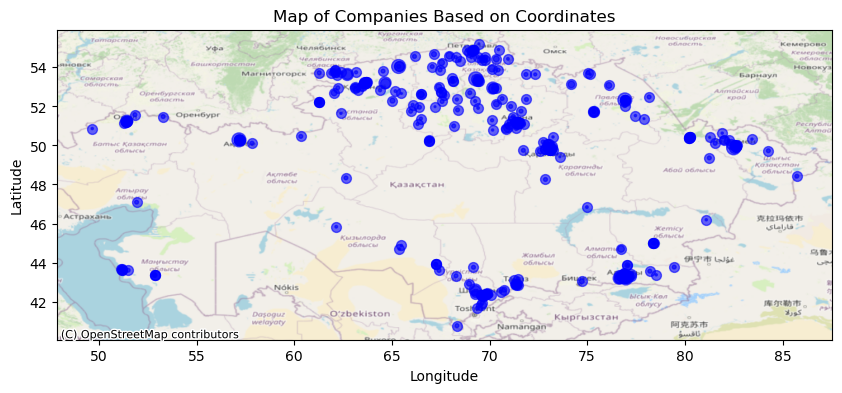

In [22]:
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df['Longitude'], df['Latitude']),
    crs="EPSG:4326"  # WGS84 Latitude/Longitude
)

fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(
    ax=ax,
    color='blue',
    markersize=gdf['Average_employees_estimated'] / 10,  
    alpha=0.6
)

gdf.plot(ax=ax, color='blue', markersize=50, alpha=0.6) 

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, crs=gdf.crs.to_string())

# Customize the plot
plt.title('Map of Companies Based on Coordinates')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()